## Load package

In [1]:
from logging import exception
import os
from platform import architecture
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
import torch_geometric.nn as geom_nn
from torch_geometric.nn import GCNConv
import networkx as nx
# import feature_embedding
# import PDB2Graph
import GNN_core
import argparse
import random
from os.path import exists
from multiprocessing import Pool
import multiprocessing
import torch.optim as optim
import copy
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import os
import glob

## Set training parameters and load graph

In [2]:
# set parameters
lr = 0.01
n_epochs = 100 
patience = n_epochs
ratio = [0.6, 0.2, 0.2]
batch_size = 40
hidden_channels = 12

# load graph
all_graph_path = './new_data_base/all_graph_PDB_MinMax/'
nx_files = glob.glob(os.path.join(all_graph_path, '*.nx'))
print('Total graph:',len(nx_files))

graph_dataset = [];
for i, tmp_path in enumerate(nx_files):
    loaded_data = torch.load(tmp_path)
    graph_dataset.append(loaded_data)

# print out one graph info for checking
idx_eg = 3
data = graph_dataset[idx_eg]
# print(graph_dataset[1].edge_attr)
print()
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print('Current nx path:{}'.format(nx_files[idx_eg]))

Total graph: 314

Data(x=[377, 8], edge_index=[2, 1037], y=1)
Number of nodes: 377
Number of edges: 1037
Average node degree: 2.75
Current nx path:./new_data_base/all_graph_PDB_MinMax/5GU6.nx


## Balance the data and set train/val/test set

In [3]:
# balance the data
random.seed(666)

print('____')
print('Before balance')
print('length graph_dataset',len(graph_dataset))
sum_i = 0
for i in graph_dataset:
    sum_i = sum_i + i.y

print('#Label1 and ration:',sum_i,sum_i/len(graph_dataset))
print('____')

### train test partition
graph_dataset=GNN_core.balance_dataset(graph_dataset)
print('____')
print('After balance')
print('length graph_dataset',len(graph_dataset))
sum_i = 0
for i in graph_dataset:
    sum_i = sum_i + i.y

print('#Label1 and ration:',sum_i,sum_i/len(graph_dataset))
GNN_core.get_info_dataset(graph_dataset,verbose=True)
print('____')

#train_test_partition=int(partition_ratio*len(graph_dataset))
assert(ratio[0]+ratio[1]+ratio[2]==1)
part1 = int(len(graph_dataset)*ratio[0])
part2 = part1 + int(len(graph_dataset)*ratio[1])
part3 = part2 + int(len(graph_dataset)*ratio[2])

train_dataset = graph_dataset[:part1]
test_dataset = graph_dataset[part1:part2]
val_dataset = graph_dataset[part2:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

print('____')
print('Length test_dataset',len(test_dataset))
sum_i = 0
for i in test_dataset:
    sum_i = sum_i + i.y

print('#Label1 and ration:',sum_i,sum_i/len(test_dataset))
GNN_core.get_info_dataset(test_dataset,verbose=True)
print('____')
print('Data info for checking randomness:')
for i, data in enumerate(val_dataset):
    print(i, data)
#     if i == 10:
#         break

____
Before balance
length graph_dataset 314
#Label1 and ration: tensor(121) tensor(0.3854)
____
____
After balance
length graph_dataset 251
#Label1 and ration: tensor(121) tensor(0.4821)
In this dataset, there are 130 inputs labeled "0" and 121 inputs labeled "1".
____
Number of training graphs: 150
Number of test graphs: 50
Number of val graphs: 51
____
Length test_dataset 50
#Label1 and ration: tensor(22) tensor(0.4400)
In this dataset, there are 28 inputs labeled "0" and 22 inputs labeled "1".
____
Data info for checking randomness:
0 Data(x=[712, 8], edge_index=[2, 1754], y=1)
1 Data(x=[1092, 8], edge_index=[2, 3000], y=1)
2 Data(x=[5045, 8], edge_index=[2, 12994], y=1)
3 Data(x=[207, 8], edge_index=[2, 526], y=1)
4 Data(x=[206, 8], edge_index=[2, 1710], y=0)
5 Data(x=[711, 8], edge_index=[2, 2971], y=1)
6 Data(x=[307, 8], edge_index=[2, 835], y=1)
7 Data(x=[799, 8], edge_index=[2, 2315], y=0)
8 Data(x=[5205, 8], edge_index=[2, 14460], y=1)
9 Data(x=[1833, 8], edge_index=[2, 4979]

## Load best model

In [6]:
import GNN_core

from importlib import reload
reload(GNN_core)
# load model
device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_node_features=len(graph_dataset[0].x[0])
num_classes=2

arch = 'GAT_jz'
num_layers = 0
if arch == 'GCN':
    best_model = GNN_core.GCN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GNN':
    best_model = GNN_core.GNN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GTN':
    best_model = GNN_core.GTN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GAT_jz':
    heads = 1
    best_model = GNN_core.GAT_jz(hidden_channels,num_node_features=num_node_features,
                            num_classes=num_classes,num_layers=num_layers,heads=heads)
    

save_path = os.path.join('.','model','{}_best_model.pth'.format(arch))
best_model.load_state_dict(torch.load(save_path))
best_model.to(device)
best_model.eval()

cpu


GAT_jz(
  (linear): Linear(in_features=8, out_features=8, bias=True)
  (bn0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GATConv(8, 12, heads=1)
  (bn1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(12, 12, heads=1)
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(12, 12, heads=1)
  (bn3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): ModuleList()
  (bn): ModuleList()
  (lin): Linear(in_features=12, out_features=2, bias=True)
)

## Import package and inference dataloader

In [7]:
from torch_geometric.loader import DataLoader

ex_loader = DataLoader(val_dataset[:], batch_size=1, shuffle=False)
for i, data in enumerate(ex_loader):
    print(i,data)
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    if i==2:
        break

0 DataBatch(x=[712, 8], edge_index=[2, 1754], y=[1], batch=[712], ptr=[2])
Number of nodes: 712
Number of edges: 1754
Average node degree: 2.46
1 DataBatch(x=[1092, 8], edge_index=[2, 3000], y=[1], batch=[1092], ptr=[2])
Number of nodes: 1092
Number of edges: 3000
Average node degree: 2.75
2 DataBatch(x=[5045, 8], edge_index=[2, 12994], y=[1], batch=[5045], ptr=[2])
Number of nodes: 5045
Number of edges: 12994
Average node degree: 2.58


(6, 2)
{0: array([1.16666667, 1.46666667]), 1: array([7.33333333, 9.        ])}


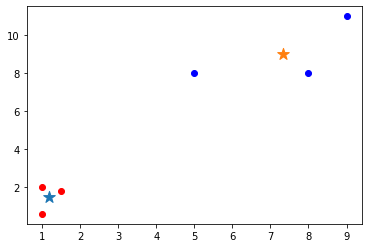

In [8]:
class K_Means(object):
    def __init__(self, k=2, tolerance=0.0001, max_iter=300):
        self.k_ = k
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter

    def fit(self, data):
        self.centers_ = {}
        for i in range(self.k_):
            self.centers_[i] = data[i]

        for i in range(self.max_iter_):
            self.clf_ = {}
            self.clfindex_ = {}
            for i in range(self.k_):
                self.clf_[i] = []
                self.clfindex_[i] = []
            # print("centers:",self.centers_)
            for idx, feature in enumerate(data):
                # distances = [np.linalg.norm(feature-self.centers[center]) for center in self.centers]
                distances = []
                for center in self.centers_:
                    # eular distance
                    # np.sqrt(np.sum((features-self.centers_[center])**2))
                    distances.append(np.linalg.norm(feature - self.centers_[center]))
                classification = distances.index(min(distances))
                self.clf_[classification].append(feature)
                self.clfindex_[classification].append(idx)

            # print("cluster:",self.clf_)
            prev_centers = dict(self.centers_)
            for c in self.clf_:
                self.centers_[c] = np.average(self.clf_[c], axis=0)

            # center in tolerance
            optimized = True
            for center in self.centers_:
                org_centers = prev_centers[center]
                cur_centers = self.centers_[center]
                if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
                    optimized = False
            if optimized:
                break

    def predict(self, p_data):
        distances = [np.linalg.norm(p_data - self.centers_[center]) for center in self.centers_]
        index = distances.index(min(distances))
        return index


if __name__ == '__main__':
    x = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])
    print(x.shape)
    k_means = K_Means(k=2, max_iter=100)
    k_means.fit(x)
    print(k_means.centers_)
    for center in k_means.centers_:
        plt.scatter(k_means.centers_[center][0], k_means.centers_[center][1], marker='*', s=150)

    for cat in k_means.clf_:
        for point in k_means.clf_[cat]:
            plt.scatter(point[0], point[1], c=('r' if cat == 0 else 'b'))

#     predict = [[2, 1], [6, 9]]
#     for feature in predict:
#         cat = k_means.predict(predict)
#         plt.scatter(feature[0], feature[1], c=('r' if cat == 0 else 'b'), marker='x')

    plt.show()

In [9]:
print(k_means.clf_)
print(k_means.clfindex_)

{0: [array([1., 2.]), array([1.5, 1.8]), array([1. , 0.6])], 1: [array([5., 8.]), array([8., 8.]), array([ 9., 11.])]}
{0: [0, 1, 4], 1: [2, 3, 5]}


## clustering and inference on entire dataset

In [108]:
for i, data in enumerate(ex_loader):
    if i != 4:
        continue
#     if data.x.shape[0] > 500:
#         continue
        
    print('\nCurrent ID:',i)
    print(data)
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print('Labels:',data.y)
    print('Batch:',data.batch.shape)
    
    x, edge_index = data.x, data.edge_index
    out = best_model(x, edge_index, data.batch)  
    pred = out.argmax(dim=1)
    print('Whole graph output {} and pred {}'.format(out, pred))
    
    
    x = x.float().numpy()
    k_means = K_Means(k=2, max_iter=1000)  ### Please fine tune ###
    k_means.fit(x)
    
    # find edge
    total_edge_list = list()
    total_edge_index_list = list()
    for ki in k_means.clf_.keys():
        print('\nCurrent k-means cluster sub-graph:',ki)
        ki_edge_list = list()
        ki_edge_index_list = list()
        current_cluster = k_means.clfindex_[ki]
#         print(current_cluster)
        for j in range(edge_index.shape[1]):
            current_edge = edge_index[:,j]
            result = all(elem in current_cluster for elem in current_edge)
            if result==True:
                ki_edge_index_list.append(current_edge)
                
                idx1 = current_cluster.index(current_edge[0])
                idx2 = current_cluster.index(current_edge[1])
                ki_edge_list.append(torch.tensor([idx1,idx2]))
        
        ki_edge = torch.transpose(torch.stack(ki_edge_list,dim=0), 0, 1).to(device)
        print('Number of nodes of k-means cluster {}: {}'.format(ki+1, len(k_means.clfindex_[ki])))
        print('Shape of edge of k-means cluster {}: {}'.format(ki+1, ki_edge.shape))
        
        ki_edge_index = torch.transpose(torch.stack(ki_edge_index_list,dim=0), 0, 1)
        print('Shape of edge index of k-means cluster {}: {}'.format(ki+1, ki_edge_index.shape))
#         print(ki_edge)
#         print(torch.max(ki_edge))
        
        
        ki_x = torch.from_numpy(np.asarray(k_means.clf_[ki])).to(device)
        # define new data
        ki_data = Data(x=ki_x, edge_index=ki_edge, y=data.y)
        current_batch = torch.zeros(len(k_means.clfindex_[ki]))
        current_batch = current_batch.to(torch.int64).to(device)
        out = best_model(ki_data.x, ki_data.edge_index, current_batch)  
        pred = out.argmax(dim=1)
        
    
#         explanation = explainer(x=ki_data.x.to(device), 
#                                 edge_index=ki_data.edge_index.to(device), 
#                                 batch = current_batch.to(device)
#                                )
#         get_pre = explainer.get_prediction(x=ki_data.x, edge_index=ki_data.edge_index, batch=current_batch)
#         get_pre_tar = explainer.get_target(get_pre)
#         print(get_pre, get_pre_tar)
        print('Current output {} and pred {}'.format(out, pred))
        
        # record all new cluster edge
        total_edge_list.append(ki_edge)
        total_edge_index_list.append(ki_edge_index)
        del ki_data,current_batch#,ki_edge,ki_x
    
    if i == 0:
        break


Current ID: 4
DataBatch(x=[206, 8], edge_index=[2, 1710], y=[1], batch=[206], ptr=[2])
Number of nodes: 206
Number of edges: 1710
Average node degree: 8.30
Labels: tensor([0])
Batch: torch.Size([206])
Whole graph output tensor([[ 1.3091, -1.3714]], grad_fn=<AddmmBackward0>) and pred tensor([0])

Current k-means cluster sub-graph: 0


/tmp/ipykernel_63413/56518136.py:40: RuntimeWarning: invalid value encountered in divide
  if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
/tmp/ipykernel_63413/56518136.py:40: RuntimeWarning: divide by zero encountered in divide
  if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:


Number of nodes of k-means cluster 1: 82
Shape of edge of k-means cluster 1: torch.Size([2, 545])
Shape of edge index of k-means cluster 1: torch.Size([2, 545])
Current output tensor([[ 7.7820, -7.4980]], grad_fn=<AddmmBackward0>) and pred tensor([0])

Current k-means cluster sub-graph: 1
Number of nodes of k-means cluster 2: 124
Shape of edge of k-means cluster 2: torch.Size([2, 815])
Shape of edge index of k-means cluster 2: torch.Size([2, 815])
Current output tensor([[-14.5553,  13.9640]], grad_fn=<AddmmBackward0>) and pred tensor([1])


In [16]:
from torch_geometric.data import Data
from torch_geometric.explain import \
    Explainer, Explanation, GNNExplainer, CaptumExplainer, PGExplainer

In [109]:
for i, data in enumerate(ex_loader):
#     if data.x.shape[0] > 500:
#         continue
    if i != 4:
        continue
        
    print('\nCurrent ID:',i)
    print(data)
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print('Labels:',data.y)
    print('Batch:',data.batch.shape)
    
    # GNNExplainer
    explainer = Explainer(
        model=best_model,
        algorithm=GNNExplainer(epochs=300, lr=0.01), ### Please fine tune ###
        explanation_type='model',
        node_mask_type='attributes', # attributes
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='raw',  # Model returns log probabilities.
        ),
        threshold_config=dict(
            threshold_type='topk', #topk_hard
            value=int(data.num_edges*0.5)
        ) ### Please fine tune ###
    )

    explanation = explainer(x=data.x, 
                            edge_index=data.edge_index, 
                            batch = data.batch
                           )
    print('Explanation:')
    print(explanation)
    print('explanation target:',explanation.target)
    
    print('\nShape of edge index of k-means cluster 1: {}'.format(total_edge_index_list[0].shape))
    if i == 0:
        break


Current ID: 4
DataBatch(x=[206, 8], edge_index=[2, 1710], y=[1], batch=[206], ptr=[2])
Number of nodes: 206
Number of edges: 1710
Average node degree: 8.30
Labels: tensor([0])
Batch: torch.Size([206])
Explanation:
Explanation(node_mask=[206, 8], edge_mask=[1710], prediction=[1, 2], target=[1], x=[206, 8], edge_index=[2, 1710], batch=[206])
explanation target: tensor([0])

Shape of edge index of k-means cluster 1: torch.Size([2, 545])


In [110]:
# explainer
edge_mask_logic = explanation.edge_mask>0
print(torch.sum(edge_mask_logic))

masked_edge_l = list()
for i, flag in enumerate(edge_mask_logic):
    if flag==True:
        tmp = explanation.edge_index[:,i].to(torch.int64)
        tmp = tmp.numpy()
        masked_edge_l.append([tmp[0], tmp[1]])
        
print('explainer edge:',len(masked_edge_l))

# kmeans
ki_edge = total_edge_index_list[0] # change according to sub-graph index size

kmeans_edge_l = list()
for i in range(ki_edge.shape[-1]):
    tmp = ki_edge[:,i].to(torch.int64)
    tmp = tmp.numpy()
    kmeans_edge_l.append([tmp[0], tmp[1]])
    
print('kmeans edge:',len(kmeans_edge_l))

# IoU
intersection = [i for i in masked_edge_l if i in kmeans_edge_l]
print('intersection:',len(intersection))

union = kmeans_edge_l
for tmp in masked_edge_l:
    if tmp in union:
        continue
    else:
        union.append(tmp)
print('union:',len(union))

IoU = len(intersection)/len(union)
print('IoU:',IoU)

tensor(855)
explainer edge: 855
kmeans edge: 545
intersection: 259
union: 1141
IoU: 0.22699386503067484


## Data to plot
### 1. Adjacency matrix

torch.Size([2, 835])
torch.Size([1, 307, 307])


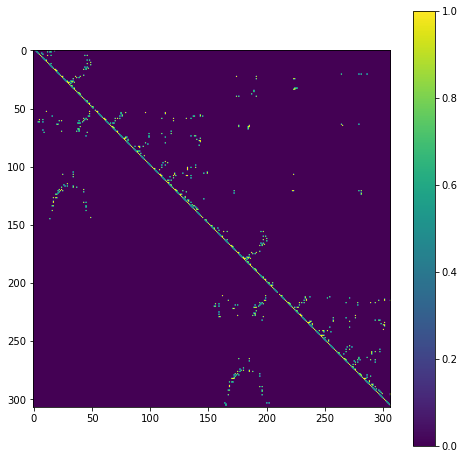

tensor([[ 52,  53,  53,  53,  53,  54,  54,  54,  54,  54,  55,  55,  55,  55],
        [ 53,  54,  11,  48,  55,  55,  96,  75,  79, 113,  56, 113,  75,  48]])

In [158]:
import torch
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt

graph_list = []
for i, tmp_g in enumerate(val_dataset):
    node = tmp_g.x
    updated_data = Data(x=node[:,-3:], edge_index=tmp_g.edge_index, y=tmp_g.y)
    graph_list.append(updated_data)

graph_idx = 6 ############## index of graph to plot
current_graph = graph_list[graph_idx]

print(current_graph.edge_index.shape)

adj_matrix = to_dense_adj(current_graph.edge_index)
print(adj_matrix.shape)

# a = adj_matrix[0,...]
a = adj_matrix[0,:500,:500] 
fig = plt.figure(figsize=(8,8))
# plt.xticks([])
# plt.yticks([])
plt.imshow(a)
plt.colorbar()
plt.show()

current_graph.edge_index[:,:14]